Maximize return

Expected Annual Return: 60.97%
Expected Annual Risk: 21.29%
Sharpe Ratio (assuming 0% risk-free rate): 2.86

Optimal Portfolio Weights:

Technology (30.00%):
  NVDA: 20.00%
  GOOGL: 10.00%

Consumer Discretionary (30.00%):
  AMZN: 20.00%
  TSLA: 10.00%

Consumer Staples (20.00%):
  WMT: 20.00%

Industrials (20.00%):
  GE: 20.00%


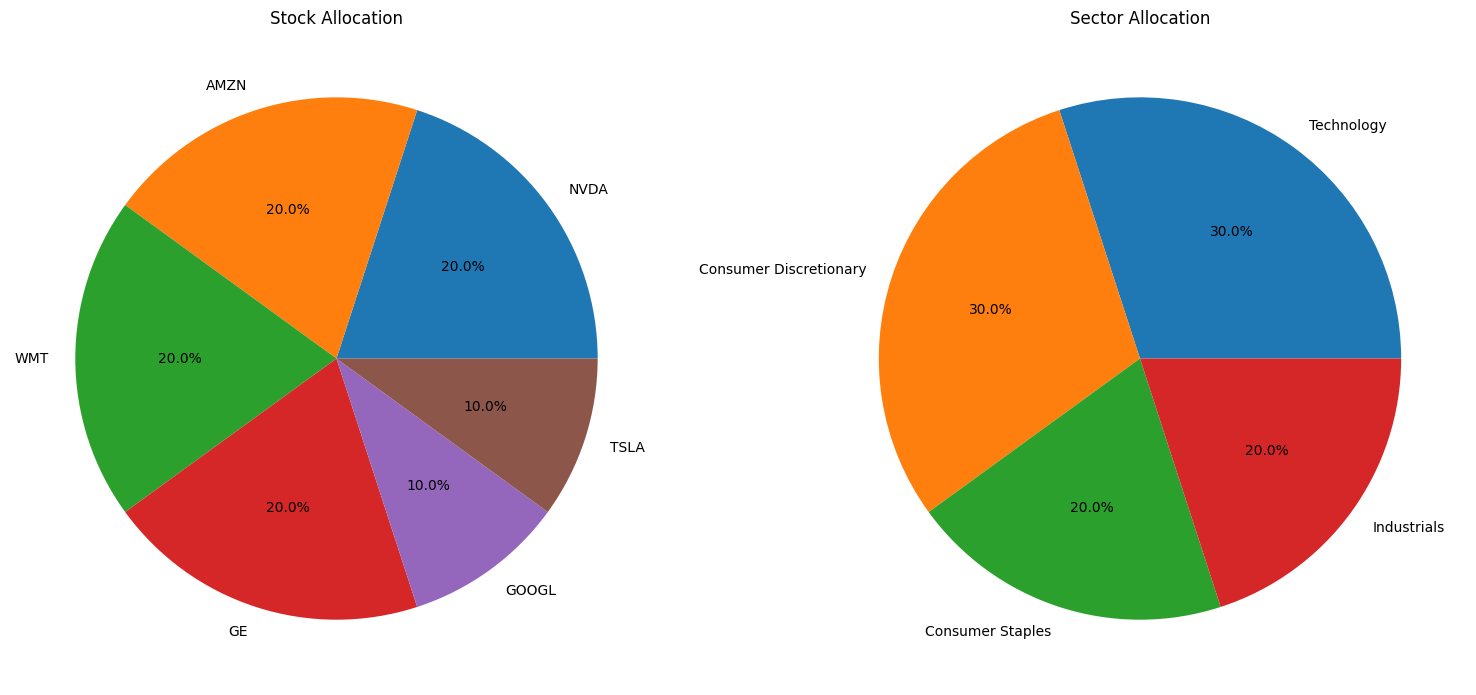

In [1]:
import pandas as pd
import numpy as np
import pulp as plp
import matplotlib.pyplot as plt

def portfolio_optimization(file_path, sectors_dict, max_stock_weight=20, max_sector_weight=30):
    """
    Perform portfolio optimization with the following constraints:
    1. A stock weight cannot be more than max_stock_weight (%)
    2. A sector weight cannot be more than max_sector_weight (%)
    
    Args:
        file_path (str): Path to the CSV file with stock prices
        sectors_dict (dict): Dictionary mapping sectors to lists of stock tickers
        max_stock_weight (float): Maximum weight for any single stock (in percentage)
        max_sector_weight (float): Maximum weight for any sector (in percentage)
        
    Returns:
        dict: Optimized portfolio weights
        float: Expected portfolio return
        float: Expected portfolio risk (standard deviation)
    """
    # Load stock data
    df = pd.read_csv(file_path)
    df.set_index('Date', inplace=True)
    
    # Calculate returns
    returns = df.pct_change().dropna()
    
    # Calculate expected returns (annualized)
    expected_returns = returns.mean() * 252
    
    # Calculate covariance matrix (annualized)
    cov_matrix = returns.cov() * 252
    
    # Create a list of all stocks
    stocks = list(returns.columns)
    
    # Create flat list of all stocks to ensure they are in sectors_dict
    all_sector_stocks = [stock for stocks_list in sectors_dict.values() for stock in stocks_list]
    missing_stocks = [stock for stock in stocks if stock not in all_sector_stocks]
    if missing_stocks:
        raise ValueError(f"The following stocks are not in any sector: {missing_stocks}")
    
    # Create a dictionary mapping stocks to sectors
    stock_to_sector = {}
    for sector, sector_stocks in sectors_dict.items():
        for stock in sector_stocks:
            if stock in stocks:  # Only include stocks that are in our data
                stock_to_sector[stock] = sector
    
    # Create the optimization problem
    prob = plp.LpProblem("Portfolio_Optimization", plp.LpMaximize)
    
    # Define variables (portfolio weights)
    weights = {stock: plp.LpVariable(f"w_{stock}", lowBound=0, upBound=max_stock_weight/100) for stock in stocks}
    
    # Set the objective function (maximize expected return)
    prob += plp.lpSum([weights[stock] * expected_returns[stock] for stock in stocks]), "Portfolio_Return"
    
    # Constraint 1: Weights sum to 1 (100%)
    prob += plp.lpSum([weights[stock] for stock in stocks]) == 1, "Sum_Weights"
    
    # Constraint 2: Sector weights limited
    for sector in sectors_dict.keys():
        sector_stocks = [stock for stock in stocks if stock_to_sector.get(stock) == sector]
        if sector_stocks:  # Only add constraint if there are stocks in this sector
            prob += plp.lpSum([weights[stock] for stock in sector_stocks]) <= max_sector_weight/100, f"Max_{sector}_Weight"
    
    # Solve the problem
    prob.solve(plp.PULP_CBC_CMD(msg=False))
    
    # Get the optimal weights
    optimal_weights = {stock: weights[stock].value() for stock in stocks}
    
    # Calculate expected portfolio return and risk
    expected_portfolio_return = sum(optimal_weights[stock] * expected_returns[stock] for stock in stocks)
    
    # Calculate portfolio risk
    portfolio_risk = 0
    for stock1 in stocks:
        for stock2 in stocks:
            portfolio_risk += optimal_weights[stock1] * optimal_weights[stock2] * cov_matrix.loc[stock1, stock2]
    portfolio_risk = np.sqrt(portfolio_risk)
    
    # Convert weights to percentages for display
    weight_percentages = {stock: weight * 100 for stock, weight in optimal_weights.items()}
    
    return weight_percentages, expected_portfolio_return * 100, portfolio_risk * 100

def display_results(weights, expected_return, risk, sectors_dict):
    """Display the optimization results"""
    # Sort weights by value in descending order
    sorted_weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1], reverse=True) if v > 0.01}
    
    print(f"Expected Annual Return: {expected_return:.2f}%")
    print(f"Expected Annual Risk: {risk:.2f}%")
    print(f"Sharpe Ratio (assuming 0% risk-free rate): {expected_return / risk:.2f}")
    print("\nOptimal Portfolio Weights:")
    
    # Calculate sector weights
    sector_weights = {}
    for sector, stocks in sectors_dict.items():
        sector_weight = sum(weights.get(stock, 0) for stock in stocks)
        if sector_weight > 0.01:  # Only show sectors with significant weight
            sector_weights[sector] = sector_weight
    
    # Display stock weights by sector
    for sector, sector_weight in sorted(sector_weights.items(), key=lambda item: item[1], reverse=True):
        print(f"\n{sector} ({sector_weight:.2f}%):")
        sector_stocks = sectors_dict[sector]
        for stock in sector_stocks:
            if stock in weights and weights[stock] > 0.01:
                print(f"  {stock}: {weights[stock]:.2f}%")
    
    # Create pie charts for visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Stock allocation pie chart (only showing stocks with weight > 1%)
    stocks_to_plot = {k: v for k, v in sorted_weights.items() if v > 1}
    ax1.pie(stocks_to_plot.values(), labels=stocks_to_plot.keys(), autopct='%1.1f%%')
    ax1.set_title('Stock Allocation')
    
    # Sector allocation pie chart
    sectors_to_plot = {k: v for k, v in sector_weights.items() if v > 1}
    ax2.pie(sectors_to_plot.values(), labels=sectors_to_plot.keys(), autopct='%1.1f%%')
    ax2.set_title('Sector Allocation')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    file_path = r"C:\Users\elifr\OneDrive\Desktop\PROJECTS\Proje101\close_prices.csv"
    
    # Stock sectors
    sectors_dict = {
        "Technology": ["AAPL", "MSFT", "NVDA", "GOOGL"],
        "Healthcare": ["JNJ", "PFE", "UNH", "MRNA"],
        "Financials": ["JPM", "BAC", "GS", "V"],
        "Consumer Discretionary": ["AMZN", "TSLA", "NKE", "MCD"],
        "Consumer Staples": ["PG", "KO", "WMT", "UL"],
        "Energy": ["XOM", "CVX", "BP", "NEE"],
        "Industrials": ["GE", "CAT", "BA", "HON"],
        "Utilities": ["DUK", "SO"],
        "Real Estate": ["AMT", "SPG", "O"],
        "Materials": ["FCX", "DOW", "LIN"]
    }
    
    # Run optimization
    weights, expected_return, risk = portfolio_optimization(file_path, sectors_dict)
    
    # Display results
    display_results(weights, expected_return, risk, sectors_dict)

Maximize sharpe

Expected Annual Return: 44.42%
Expected Annual Risk: 12.00%
Risk-Free Rate: 2.00%
Sharpe Ratio: 3.53

Optimal Portfolio Weights:

Consumer Staples (29.13%):
  PG: 5.18%
  KO: 3.95%
  WMT: 20.00%

Utilities (19.73%):
  SO: 19.73%

Technology (17.31%):
  AAPL: 2.20%
  NVDA: 11.68%
  GOOGL: 3.43%

Industrials (15.50%):
  GE: 15.50%

Financials (15.32%):
  JPM: 13.66%
  V: 1.66%

Consumer Discretionary (2.45%):
  AMZN: 2.45%

Healthcare (0.55%):
  UNH: 0.55%


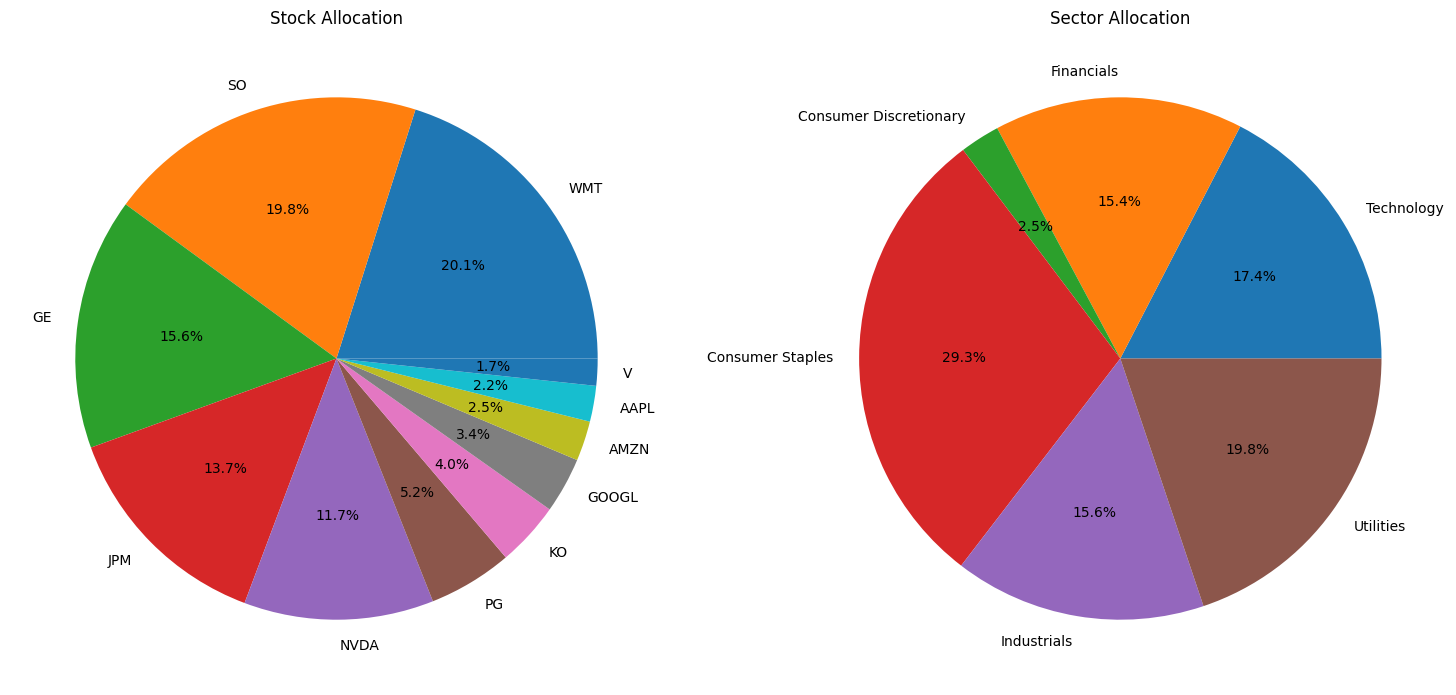

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

def portfolio_optimization(file_path, sectors_dict, max_stock_weight=20, max_sector_weight=30, risk_free_rate=0.0):
    """
    Perform portfolio optimization to maximize Sharpe ratio with the following constraints:
    1. A stock weight cannot be more than max_stock_weight (%)
    2. A sector weight cannot be more than max_sector_weight (%)
    
    Args:
        file_path (str): Path to the CSV file with stock prices
        sectors_dict (dict): Dictionary mapping sectors to lists of stock tickers
        max_stock_weight (float): Maximum weight for any single stock (in percentage)
        max_sector_weight (float): Maximum weight for any sector (in percentage)
        risk_free_rate (float): Annual risk-free rate (in decimal form)
        
    Returns:
        dict: Optimized portfolio weights
        float: Expected portfolio return
        float: Expected portfolio risk (standard deviation)
        float: Portfolio Sharpe ratio
    """
    # Load stock data
    df = pd.read_csv(file_path)
    df.set_index('Date', inplace=True)
    
    # Calculate returns
    returns = df.pct_change().dropna()
    
    # Calculate expected returns (annualized)
    expected_returns = returns.mean() * 252
    
    # Calculate covariance matrix (annualized)
    cov_matrix = returns.cov() * 252
    
    # Create a list of all stocks
    stocks = list(returns.columns)
    
    # Create flat list of all stocks to ensure they are in sectors_dict
    all_sector_stocks = [stock for stocks_list in sectors_dict.values() for stock in stocks_list]
    missing_stocks = [stock for stock in stocks if stock not in all_sector_stocks]
    if missing_stocks:
        raise ValueError(f"The following stocks are not in any sector: {missing_stocks}")
    
    # Create a dictionary mapping stocks to sectors
    stock_to_sector = {}
    for sector, sector_stocks in sectors_dict.items():
        for stock in sector_stocks:
            if stock in stocks:  # Only include stocks that are in our data
                stock_to_sector[stock] = sector
    
    # Define the negative Sharpe ratio function to minimize
    def neg_sharpe_ratio(weights_array, expected_returns, cov_matrix, risk_free_rate):
        weights_array = np.array(weights_array)
        portfolio_return = np.sum(weights_array * expected_returns)
        portfolio_stddev = np.sqrt(np.dot(weights_array.T, np.dot(cov_matrix, weights_array)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
        return -sharpe_ratio  # Negative because we want to maximize, but scipy minimizes
    
    # Define the constraint that weights sum to 1
    def sum_constraint(weights):
        return np.sum(weights) - 1
    
    # Initial guess (equal weights)
    initial_weights = np.array([1/len(stocks)] * len(stocks))
    
    # Define bounds for each stock weight (0 to max_stock_weight)
    bounds = tuple((0, max_stock_weight/100) for _ in range(len(stocks)))
    
    # Define sector constraints
    sector_constraints = []
    for sector in sectors_dict.keys():
        sector_stocks_indices = [i for i, stock in enumerate(stocks) if stock_to_sector.get(stock) == sector]
        if sector_stocks_indices:
            def make_sector_constraint(indices, max_weight=max_sector_weight/100):
                return lambda weights: max_weight - sum(weights[i] for i in indices)
            sector_constraints.append({
                'type': 'ineq',
                'fun': make_sector_constraint(sector_stocks_indices)
            })
    
    # Set up the constraints
    constraints = [{'type': 'eq', 'fun': sum_constraint}] + sector_constraints
    
    # Solve the optimization problem
    result = sco.minimize(
        neg_sharpe_ratio,
        initial_weights,
        args=(expected_returns.values, cov_matrix.values, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}
    )
    
    # Get the optimal weights
    optimal_weights_array = result.x
    optimal_weights = {stock: weight for stock, weight in zip(stocks, optimal_weights_array)}
    
    # Calculate expected portfolio return and risk
    expected_portfolio_return = sum(optimal_weights[stock] * expected_returns[stock] for stock in stocks)
    
    # Calculate portfolio risk
    portfolio_risk = 0
    for stock1 in stocks:
        for stock2 in stocks:
            portfolio_risk += optimal_weights[stock1] * optimal_weights[stock2] * cov_matrix.loc[stock1, stock2]
    portfolio_risk = np.sqrt(portfolio_risk)
    
    # Calculate Sharpe ratio
    sharpe_ratio = (expected_portfolio_return - risk_free_rate) / portfolio_risk
    
    # Convert weights to percentages for display
    weight_percentages = {stock: weight * 100 for stock, weight in optimal_weights.items()}
    
    return weight_percentages, expected_portfolio_return * 100, portfolio_risk * 100, sharpe_ratio

def display_results(weights, expected_return, risk, sharpe_ratio, sectors_dict, risk_free_rate=0.0):
    """Display the optimization results"""
    # Sort weights by value in descending order
    sorted_weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1], reverse=True) if v > 0.01}
    
    print(f"Expected Annual Return: {expected_return:.2f}%")
    print(f"Expected Annual Risk: {risk:.2f}%")
    print(f"Risk-Free Rate: {risk_free_rate * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print("\nOptimal Portfolio Weights:")
    
    # Calculate sector weights
    sector_weights = {}
    for sector, stocks in sectors_dict.items():
        sector_weight = sum(weights.get(stock, 0) for stock in stocks)
        if sector_weight > 0.01:  # Only show sectors with significant weight
            sector_weights[sector] = sector_weight
    
    # Display stock weights by sector
    for sector, sector_weight in sorted(sector_weights.items(), key=lambda item: item[1], reverse=True):
        print(f"\n{sector} ({sector_weight:.2f}%):")
        sector_stocks = sectors_dict[sector]
        for stock in sector_stocks:
            if stock in weights and weights[stock] > 0.01:
                print(f"  {stock}: {weights[stock]:.2f}%")
    
    # Create pie charts for visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Stock allocation pie chart (only showing stocks with weight > 1%)
    stocks_to_plot = {k: v for k, v in sorted_weights.items() if v > 1}
    ax1.pie(stocks_to_plot.values(), labels=stocks_to_plot.keys(), autopct='%1.1f%%')
    ax1.set_title('Stock Allocation')
    
    # Sector allocation pie chart
    sectors_to_plot = {k: v for k, v in sector_weights.items() if v > 1}
    ax2.pie(sectors_to_plot.values(), labels=sectors_to_plot.keys(), autopct='%1.1f%%')
    ax2.set_title('Sector Allocation')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    file_path = r"C:\Users\elifr\OneDrive\Desktop\PROJECTS\Proje101\close_prices.csv"
    
    # Stock sectors
    sectors_dict = {
        "Technology": ["AAPL", "MSFT", "NVDA", "GOOGL"],
        "Healthcare": ["JNJ", "PFE", "UNH", "MRNA"],
        "Financials": ["JPM", "BAC", "GS", "V"],
        "Consumer Discretionary": ["AMZN", "TSLA", "NKE", "MCD"],
        "Consumer Staples": ["PG", "KO", "WMT", "UL"],
        "Energy": ["XOM", "CVX", "BP", "NEE"],
        "Industrials": ["GE", "CAT", "BA", "HON"],
        "Utilities": ["DUK", "SO"],
        "Real Estate": ["AMT", "SPG", "O"],
        "Materials": ["FCX", "DOW", "LIN"]
    }
    
    # Define risk-free rate (e.g., Treasury yield)
    risk_free_rate = 0.02  # 2% annual risk-free rate
    
    # Run optimization
    weights, expected_return, risk, sharpe_ratio = portfolio_optimization(
        file_path, sectors_dict, risk_free_rate=risk_free_rate
    )
    
    # Display results
    display_results(weights, expected_return, risk, sharpe_ratio, sectors_dict, risk_free_rate)

Benzer Çıktı


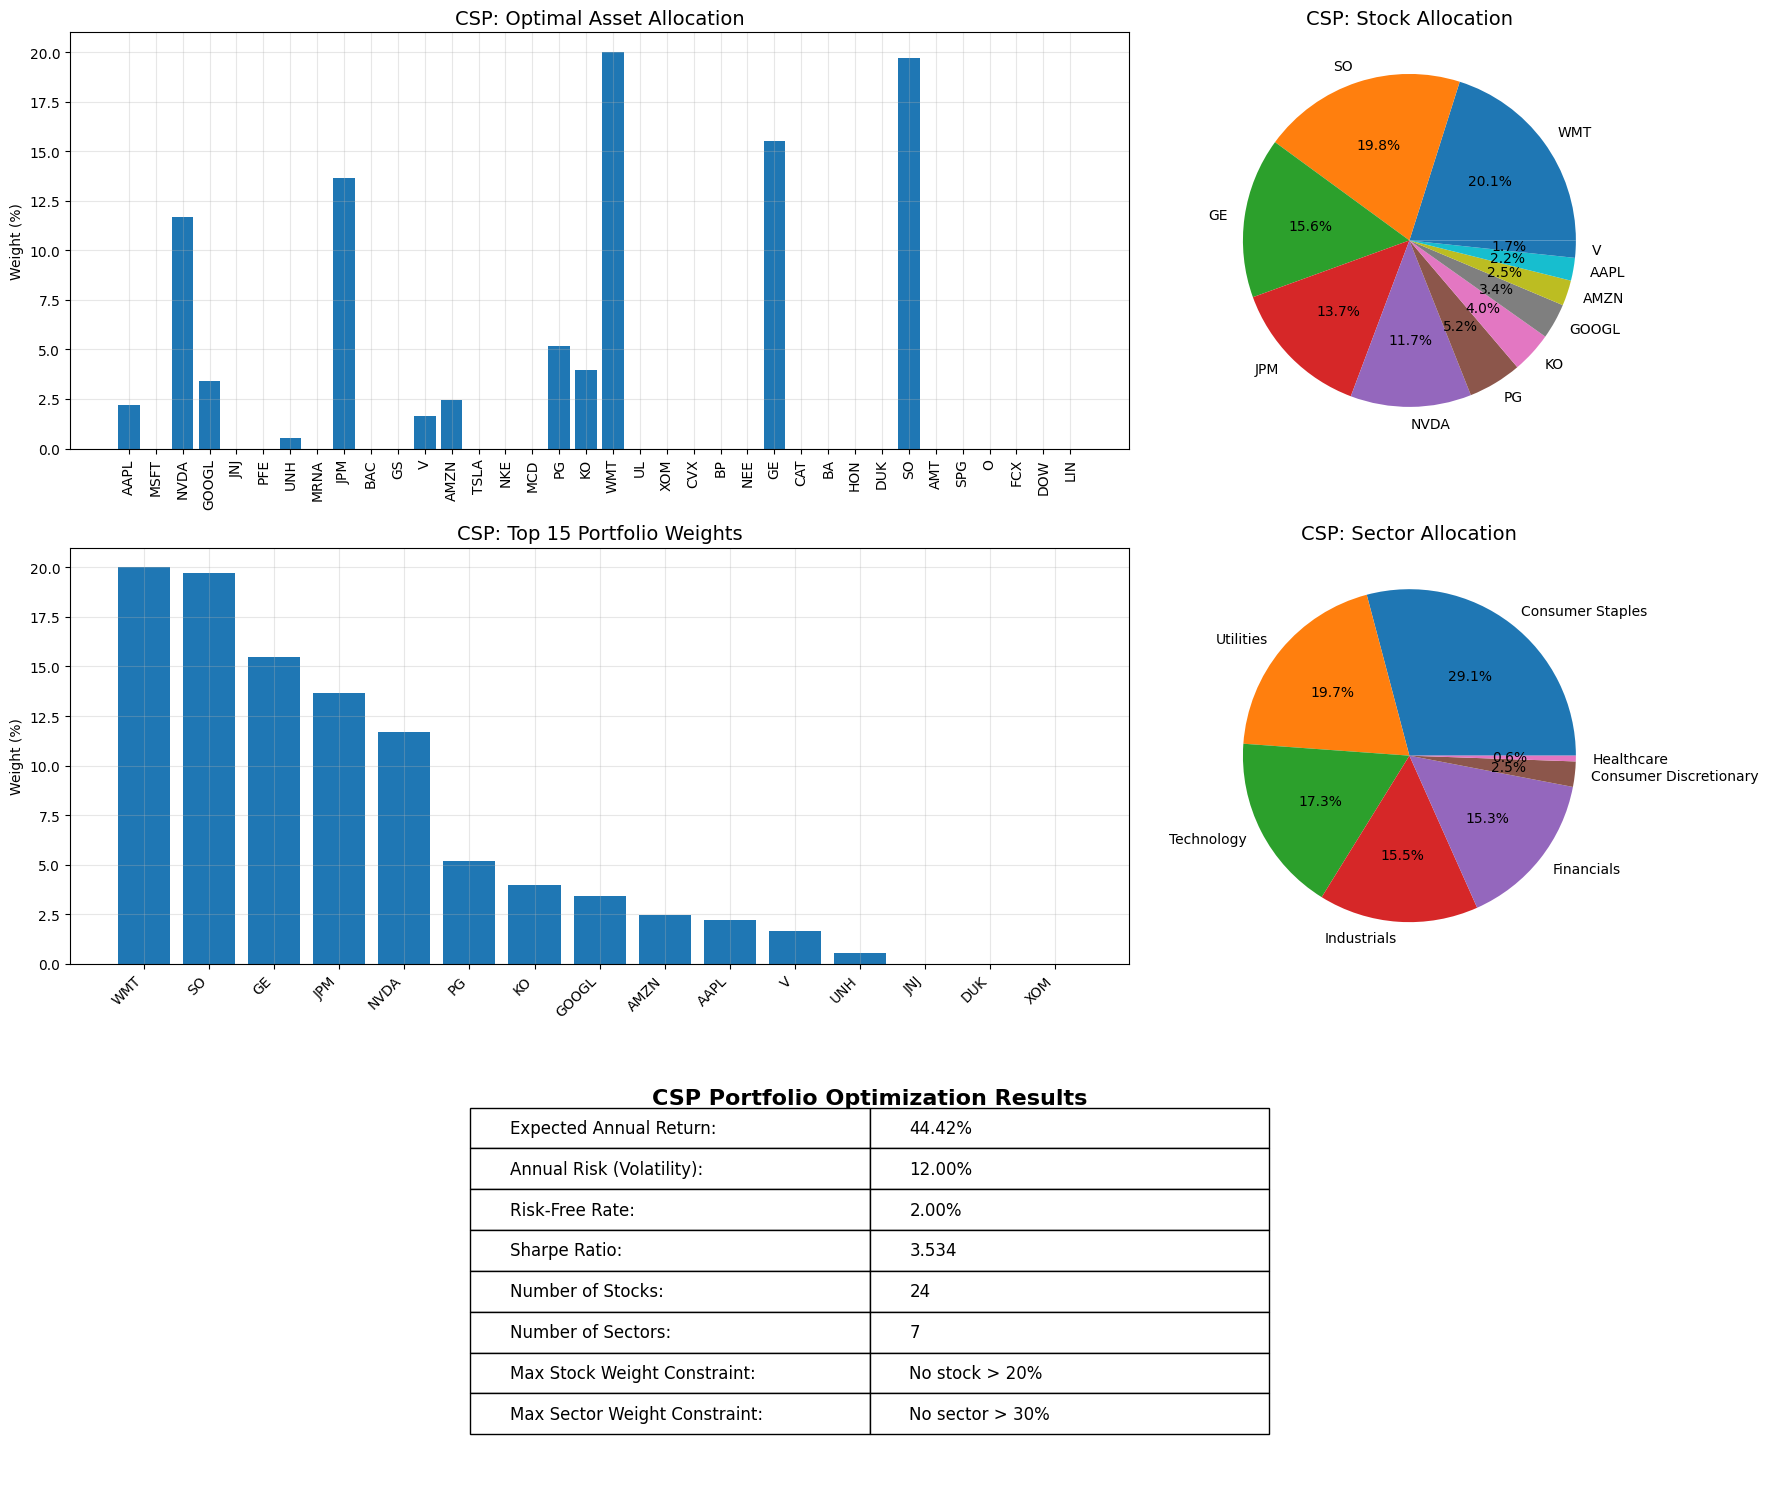

In [6]:
def visualize_csp_portfolio(weights, sectors_dict, expected_return, risk, sharpe_ratio, risk_free_rate=0.02):
    """
    Creates detailed visualizations for CSP portfolio results
    
    Args:
        weights (dict): Portfolio weights for each stock (in percentages)
        sectors_dict (dict): Dictionary mapping sectors to lists of stock tickers
        expected_return (float): Expected annual return (in percentage)
        risk (float): Expected annual risk/volatility (in percentage)
        sharpe_ratio (float): Portfolio Sharpe ratio
        risk_free_rate (float): Annual risk-free rate (in decimal)
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    
    # Convert to pandas Series for easier manipulation
    weights_series = pd.Series(weights)
    
    # Calculate sector weights
    sector_weights = {}
    for sector, stocks in sectors_dict.items():
        sector_weight = sum(weights.get(stock, 0) for stock in stocks)
        if sector_weight > 0.01:  # Only show sectors with significant weight
            sector_weights[sector] = sector_weight
    
    sector_weights_series = pd.Series(sector_weights)
    
    # Create figure for visualizations
    fig = plt.figure(figsize=(18, 15))
    
    # Set up grid for subplots
    gs = fig.add_gridspec(3, 3)
    
    # 1. Bar chart of all stock weights
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.bar(weights_series.index, weights_series.values)
    ax1.set_title('CSP: Optimal Asset Allocation', fontsize=14)
    ax1.set_ylabel('Weight (%)')
    ax1.set_xticks(range(len(weights_series.index)))
    ax1.set_xticklabels(weights_series.index, rotation=90)
    ax1.grid(True, alpha=0.3)
    
    # 2. Bar chart of significant stock weights (top 15, sorted)
    ax2 = fig.add_subplot(gs[1, :2])
    sig_weights = weights_series.sort_values(ascending=False).head(15)
    ax2.bar(sig_weights.index, sig_weights.values)
    ax2.set_title('CSP: Top 15 Portfolio Weights', fontsize=14)
    ax2.set_ylabel('Weight (%)')
    ax2.set_xticks(range(len(sig_weights.index)))
    ax2.set_xticklabels(sig_weights.index, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # 3. Pie chart of stock allocation (only showing stocks with weight > 1%)
    ax3 = fig.add_subplot(gs[0, 2])
    stocks_to_plot = weights_series[weights_series >= 1.0].sort_values(ascending=False)
    ax3.pie(stocks_to_plot.values, labels=stocks_to_plot.index, autopct='%1.1f%%')
    ax3.set_title('CSP: Stock Allocation', fontsize=14)
    
    # 4. Sector allocation pie chart
    ax4 = fig.add_subplot(gs[1, 2])
    sectors_to_plot = sector_weights_series.sort_values(ascending=False)
    ax4.pie(sectors_to_plot.values, labels=sectors_to_plot.index, autopct='%1.1f%%')
    ax4.set_title('CSP: Sector Allocation', fontsize=14)
    
    # 5. Metrics summary table
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')  # Turn off the axis
    
    # Create table data
    metrics_data = [
        ['Expected Annual Return:', f'{expected_return:.2f}%'],
        ['Annual Risk (Volatility):', f'{risk:.2f}%'],
        ['Risk-Free Rate:', f'{risk_free_rate * 100:.2f}%'],
        ['Sharpe Ratio:', f'{sharpe_ratio:.3f}'],
        ['Number of Stocks:', f'{len(weights_series[weights_series > 0])}'],
        ['Number of Sectors:', f'{len(sector_weights_series)}'],
    ]
    
    # Add constraint information
    metrics_data.append(['Max Stock Weight Constraint:', 'No stock > 20%'])
    metrics_data.append(['Max Sector Weight Constraint:', 'No sector > 30%'])
    
    # Create the table
    table = ax5.table(
        cellText=metrics_data,
        colWidths=[0.25, 0.25],
        loc='center',
        cellLoc='left'
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Add a title to the metrics section
    ax5.text(0.5, 0.9, 'CSP Portfolio Optimization Results', 
             horizontalalignment='center', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Example usage in the CSP portfolio optimization code:

# After running the optimization:
weights, expected_return, risk, sharpe_ratio = portfolio_optimization(
    file_path, sectors_dict, risk_free_rate=0.02
)

# Display detailed visualization
visualize_csp_portfolio(
    weights, 
    sectors_dict, 
    expected_return, 
    risk, 
    sharpe_ratio, 
    risk_free_rate=0.02
)
